In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
# core jax imports
import jax
import jax.numpy as jnp
from jax import jit, grad, vmap, random
import torch
import shutil

# flax is neural-network library
import flax
from flax import linen as nn
# help create state update
from flax.training import train_state

# nnx is another pytorch-like api for flax, which is still in its infancy
# from flax import nnx as nn

# optax is optimization libaray
import optax

# typing library in python, this library is useful for type-hinting and to make the function inputs/ouputs and class initialization variables to have fixed data type
from typing import Any, Callable, Sequence, Tuple

from functools import partial

from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import os

import orbax
import orbax.checkpoint as ocp
from flax.training import orbax_utils
from tqdm import trange
from functools import partial

import math

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

In [3]:
from typing import NamedTuple, Any

class TimedX(NamedTuple):
  t: Any
  x: jnp.ndarray

def gaussians(jseed, t):
  jseeds = random.split(jseed, 3)
  x_1 = random.randint(jseeds[0], minval=0, maxval=2, shape=(t.shape[0], 2))
  x_1 = x_1.astype(float)-0.5
  x_1 += 1e-1*random.normal(jseeds[1], shape=(t.shape[0],2))
  x_0 = 1e-1*random.normal(jseeds[2], shape=(t.shape[0],2))
  x_t = (1-t)*x_0 + t*x_1
  return x_0, x_1, x_t

def diamonds(jseed, t):
  jseeds = random.split(jseed, 4)
  x_1 = random.randint(jseeds[0], minval=0, maxval=2, shape=(t.shape[0], 2))
  x_1 = x_1.astype(float)-0.5
  x_1 = x_1.at[:,0].set(0.5)

  x_0 = random.randint(jseeds[1], minval=0, maxval=2, shape=(t.shape[0], 2))
  x_0 = x_0.astype(float)-0.5
  x_0 = x_0.at[:,0].set(-0.5)

  R = jnp.array([[1/math.sqrt(2),-1/math.sqrt(2)],
                 [1/math.sqrt(2),1/math.sqrt(2)]])
  x_1 += 5e-1*(random.uniform(jseeds[2], shape=(t.shape[0],2))-0.5)@R
  x_0 += 5e-1*(random.uniform(jseeds[3], shape=(t.shape[0],2))-0.5)@R
  x_t = (1-t)*x_0 + t*x_1

  return x_0, x_1, x_t


def squares(jseed, t):
  jseeds = random.split(jseed, 3)
  x_0 = random.uniform(jseeds[0], shape=(t.shape[0], 2)) - 0.5 + jnp.array([-1.0, 0])
  x_1 = random.uniform(jseeds[1], shape=(t.shape[0], 2)) - 0.5 + jnp.array([1.0, 0.0])

  # z = random.uniform(jseeds[0], shape=(t.shape[0], 2))   
  # x_0 = random.uniform(jseeds[0], shape=(t.shape[0], 2)) - 0.5 + jnp.array([-1.0, 0])
  # x_1 = random.uniform(jseeds[0], shape=(t.shape[0], 2)) - 0.5 + jnp.array([-1.0, 0])
  # x_0 = z.at[:,0].multiply(0.5) - 0.5 + jnp.array([-1.0, 0])
  x_t = (1-t)*x_0 + t*x_1

  return x_0, x_1, x_t

def chessboard(key, t):
    x = []
    y = []
    subkey_idx = 0
    n_samples = len(t)

    for i in range(-2, 2):
        for j in range(-2, 2):
            if (i + j) % 2 == 0:
                # Create new keys for each box
                key_x, key_y = jax.random.split(jax.random.fold_in(key, subkey_idx))
                subkey_idx += 1

                # Generate random samples
                x_box = jax.random.uniform(key_x, shape=(n_samples // 8,)) + i
                y_box = jax.random.uniform(key_y, shape=(n_samples // 8,)) + j

                x.append(x_box)
                y.append(y_box)

    # Concatenate lists into arrays
    x = jnp.concatenate(x)
    y = jnp.concatenate(y)

    x_0= jnp.vstack((x, y)).T
    x_1 = x_0 + jnp.array([6.0, 0])
    x_t = (1-t)*x_0 + t*x_1

    return x_0, x_1, x_t


# DEFINE THE DYNAMICS TO USE HERE
q_t = squares
# q_t = diamonds
#q_t = chessboard

In [4]:
seed = 0
np.random.seed(seed)
key = random.PRNGKey(seed)
DS = 4000
key, loc_key = random.split(key)
DATA_0, DATA_1, _ = q_t(loc_key, jnp.ones([DS,1]))

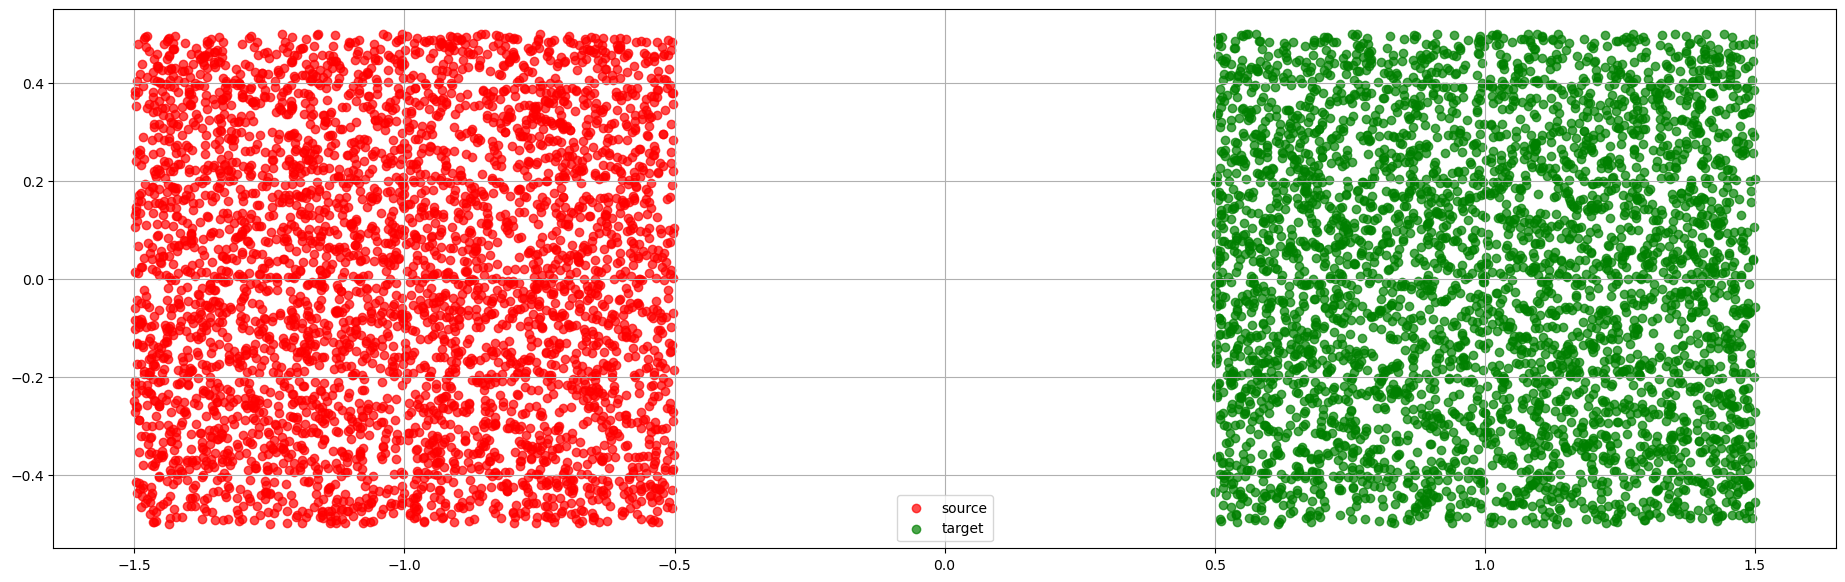

In [5]:
plt.figure(figsize=(23, 7))
plt.scatter(DATA_0[:,0], DATA_0[:,1], fc="r", alpha=0.7, label = "source")
plt.scatter(DATA_1[:,0], DATA_1[:,1], fc = "g", alpha=0.7, label = "target")
# plt.xlim(-1.5,1.5)
plt.grid()
plt.legend()

In [6]:
class Tmodel(nn.Module):
  num_hid : int
  num_out : int

  @nn.compact
  def __call__(self, inputs):
    MLP_out = nn.Sequential([
            nn.Dense(self.num_hid),
            nn.swish,
            nn.Dense(self.num_hid),
            nn.swish,
            nn.Dense(self.num_hid),
            nn.swish,
            nn.Dense(self.num_hid),
            nn.swish,
            nn.Dense(self.num_out),
        ])(inputs)
    ResConnect = inputs
    return MLP_out + ResConnect

class DualNET(nn.Module):
  num_hid : int
  num_out : int
  @nn.compact
  def __call__(self, x):
      h = nn.Dense(self.num_hid)(x)
      h = nn.swish(h)
      h = nn.Dense(self.num_hid)(h)
      h = nn.swish(h)
      h = nn.Dense(self.num_hid)(h)
      h = nn.swish(h)
      h = nn.Dense(self.num_hid)(h)
      h = nn.swish(h)
      out = nn.Dense(self.num_out)(h)
      return out


@flax.struct.dataclass
class State:
  step: int
  opt_state: Any
  model_params: Any
  ema_params: Any
  ema_rate: Any

In [7]:
### Model and parameter intialization

T_net = Tmodel(num_hid=512, num_out=2)
eta_net = DualNET(num_hid=512, num_out=1)

seed = 0
BS = 512
ema_rate = 0.999
##############################
c= 2.0
##############################
wf_lr = 1e-3
key = random.key(0)
key, *init_keys = random.split(key, 4)

# Specify the clipping threshold
clip_value = 1.0 # we do not use it in our implementation
lr = 1e-4

optimizer_T = optax.chain(optax.adam(learning_rate=lr))
optimizer_eta = optax.chain(optax.adam(learning_rate=1e-4))

init_params_T = T_net.init(init_keys[1], DATA_0[:BS])
init_params_eta = eta_net.init(init_keys[2], DATA_1[:BS])

opt_state_T = optimizer_T.init(init_params_T)
opt_state_eta = optimizer_eta.init(init_params_eta)

state_T = State(step=0, opt_state=opt_state_T, model_params=init_params_T, ema_params=init_params_T, ema_rate=ema_rate)
state_eta = State(step=0, opt_state=opt_state_eta, model_params=init_params_eta, ema_params=init_params_eta, ema_rate=ema_rate)

In [8]:
def get_loss_T(model_T, model_eta):
    def loss_T(params_T, params_eta, data_batch, key):
        x_0, x_1 = data_batch[0], data_batch[1]
        x_0p = model_T.apply(params_T, x_0)

        monge_cost = jnp.sum((x_0-x_0p)**2, axis=tuple(range(1, x_0.ndim)))
        lagrange_cost = model_eta.apply(params_eta, x_0p)
        loss = monge_cost + lagrange_cost

        return loss.mean()
    
    return loss_T

def get_loss_eta(model_T, model_eta):
    def loss_eta(params_T, params_eta, data_batch, key):
        x_0, x_1 = data_batch[0], data_batch[1]
        x_0p = model_T.apply(params_T, x_0)
        
        lagrange_loss0 = model_eta.apply(params_eta, x_0p).mean()
        lagrange_loss1 = c * jax.nn.relu(model_eta.apply(params_eta, x_1)).mean()
        loss = -(lagrange_loss0 - lagrange_loss1)
        
        return loss.mean()
    
    return loss_eta


@partial(jax.jit, static_argnums=(2,3))
def train_step(state_T, state_eta, T_steps, eta_steps, key):
    keys = random.split(key, 4)
    loss_fn_T = get_loss_T(T_net, eta_net)
    loss_fn_eta = get_loss_eta(T_net, eta_net)

    grad_fn_T = jax.value_and_grad(loss_fn_T, argnums=[0], has_aux=False)
    grad_fn_eta = jax.value_and_grad(loss_fn_eta, argnums=[1], has_aux=False)

    params_T = state_T.model_params
    params_eta = state_eta.model_params

    opt_state_T =state_T.opt_state
    opt_state_eta =state_eta.opt_state

    for iters in range(0, T_steps):
        t = random.uniform(keys[1], [BS,1])
        x0, x1, _ =  q_t(key, t)
        batch_x = [x0, x1]

        (loss_T_val), grad_T = grad_fn_T(params_T, params_eta, batch_x, keys[3])
        updates_T, opt_state_T = optimizer_T.update(grad_T[0], opt_state_T, params_T)
        params_T = optax.apply_updates(params_T, updates_T)
        new_ema_params_T = jax.tree_util.tree_map(lambda p_ema, p: p_ema * state_T.ema_rate + p * (1. - state_T.ema_rate),
                                                state_T.ema_params, params_T)
    for iters in range(0, eta_steps):
        t = random.uniform(keys[1], [BS,1])
        x0, x1, _ =  q_t(key, t)
        batch_x = [x0, x1]
        
        (loss_eta_val), grad_eta = grad_fn_eta(params_T, params_eta, batch_x, keys[4])
        updates_eta, opt_state_eta = optimizer_eta.update(grad_eta[0], opt_state_eta, params_eta)
        params_eta = optax.apply_updates(params_eta, updates_eta)
        new_ema_params_eta = jax.tree_util.tree_map(lambda p_ema, p: p_ema * state_eta.ema_rate + p * (1. - state_eta.ema_rate), 
                                                      state_eta.ema_params, params_eta)
    state_T = state_T.replace(step=state_T.step+1, opt_state=opt_state_T, model_params=params_T, ema_params=new_ema_params_T)
    state_eta = state_eta.replace(step=state_eta.step+1, opt_state=opt_state_eta, model_params=params_eta, ema_params=new_ema_params_eta)

    return state_T, state_eta, loss_T_val, loss_eta_val

_, _, _, _ = train_step(state_T, state_eta, 2, 2, loc_key)

In [9]:
num_iterations = 20_000
u0 = 0.0

T_step_num=5
eta_step_num=1
save_interval_steps =20_000
log_every_step = 1000
eval_evey_step = 1000

######
ckpt_path = "/lustre/cniel/neural-ot-ss/lagrangian-pot-flows/mnist-emnist/" + "checkpoints/"+ q_t.__name__ + "/c={0}/".format(c)
ckpt_path0 =  ckpt_path+"0"
if os.path.exists(ckpt_path0):
    shutil.rmtree(ckpt_path0)

checkpointer = ocp.Checkpointer(ocp.CompositeCheckpointHandler('state_T', 'state_eta'))
checkpointer.save(ckpt_path0, args=ocp.args.Composite(state_T=ocp.args.StandardSave(state_T),state_eta=ocp.args.StandardSave(state_eta)))   

options = ocp.CheckpointManagerOptions(max_to_keep=60)
ckpt_mgr = ocp.CheckpointManager(ckpt_path, options=options, item_names={"state_T", "state_eta"})
ckpt_mgr.save(0, args=ocp.args.Composite(state_q=ocp.args.StandardSave(state_T),state_eta=ocp.args.StandardSave(state_eta)))
#########################################
#training loop

import wandb
wandb.init(project="toy squares", name="c={}".format(c))

loss_T_plot = np.zeros(num_iterations+1)
loss_eta_plot = np.zeros(num_iterations+1)

for step in range(num_iterations+1):
  key, loc_key = random.split(key)
  state_T, state_eta, loss_T_val, loss_eta_val,  = train_step(state_T, state_eta, T_step_num, eta_step_num, key)

  if (step)%save_interval_steps == 0:
      ckpt = {"state_T": state_T, "state_eta":state_eta}
      ckpt_mgr.save(step, args=ocp.args.Composite(state_T=ocp.args.StandardSave(state_T),state_eta=ocp.args.StandardSave(state_eta)))
      ckpt_mgr.wait_until_finished()

  if (step)%log_every_step == 0:
    wandb.log({"loss_T": loss_T_val, "loss_eta": loss_eta_val}, step=step)


  loss_T_plot[step] = loss_T_val
  loss_eta_plot[step] = loss_eta_val

  if (step)%eval_evey_step == 0:
      x_t1p = T_net.apply(state_T.model_params, DATA_0)
      fig, axs = plt.subplots(1,1)
      axs.scatter(DATA_0[:,0], DATA_0[:,1], fc="r", alpha=0.7)
      axs.scatter(DATA_1[:,0], DATA_1[:,1], fc = "g", alpha=0.7)
      axs.scatter(x_t1p[:,0], x_t1p[:,1], fc = "b", alpha=0.7)
      
      axs.grid()
      wandb.log({"transported": wandb.Image(fig)})
      plt.close(fig)


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bilalriaz (bilalriaz-University of Delaware). Use `wandb login --relogin` to force relogin


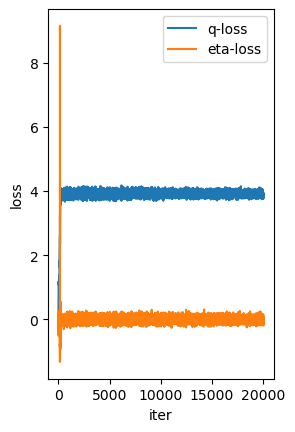

In [14]:
plt.subplot(121)
plt.plot(loss_T_plot, label="q-loss")
plt.plot(loss_eta_plot, label="eta-loss")
plt.xlabel("iter")
plt.ylabel("loss")
plt.legend()

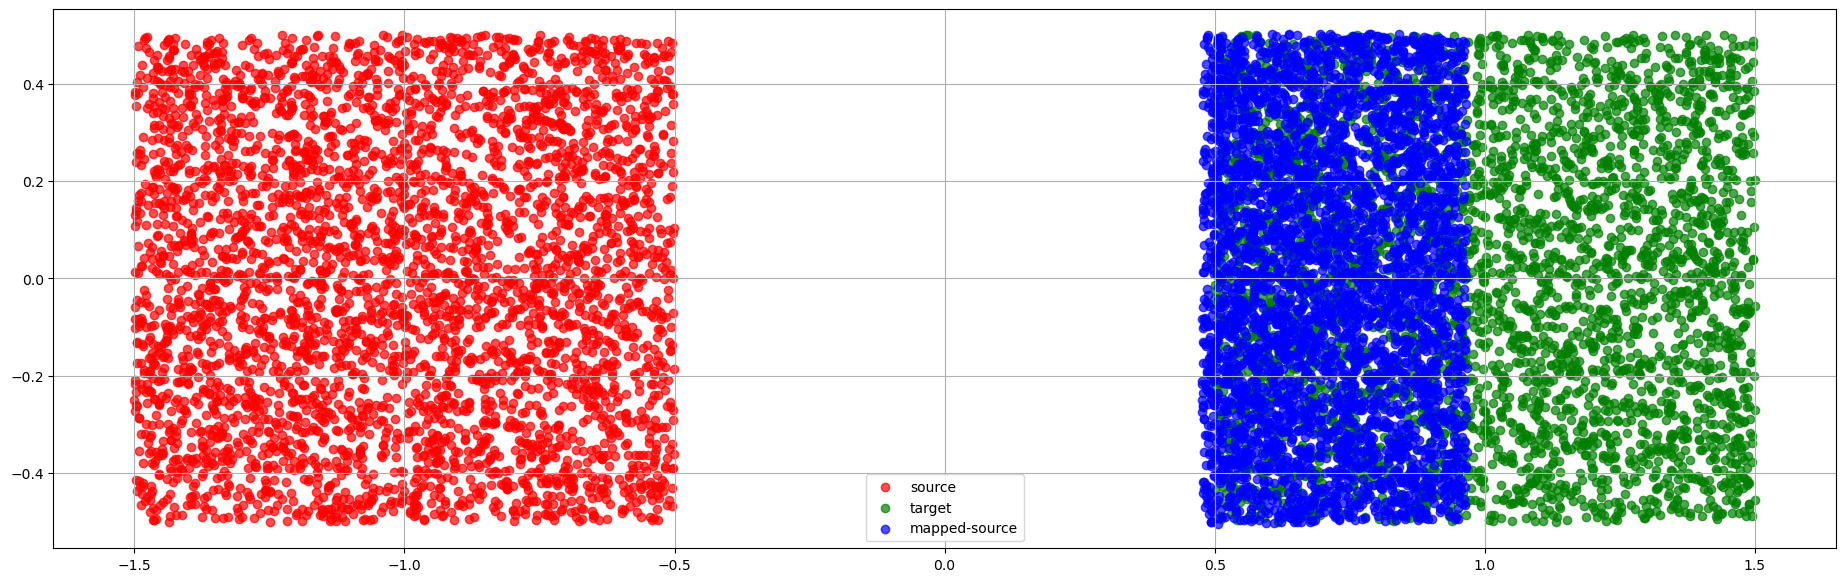

In [15]:
plt.figure(figsize=(23,7))
plt.scatter(DATA_0[:,0], DATA_0[:,1], fc="r", alpha=0.7, label = "source")
plt.scatter(DATA_1[:,0], DATA_1[:,1], fc = "g", alpha=0.7, label = "target")
x_t1p = T_net.apply(state_T.model_params, DATA_0)
plt.scatter(x_t1p[:,0], x_t1p[:,1], fc = "b", alpha=0.7, label = "mapped-source")
plt.grid()
plt.legend()


In [16]:
import jax.numpy as jnp


xd = jnp.linspace(-2.0, 2.0, 100)
yd = jnp.linspace(-1.0, 1.0, 100)

# xd = jnp.linspace(-2.0, 8.0, 100)
# yd = jnp.linspace(-2.0, 2.0, 100)


# Create meshgrid
xx0, yy0 = jnp.meshgrid(xd, yd, indexing='ij')

eta_func = lambda x: eta_net.apply(state_eta.model_params, x).squeeze()
grad_eta_func = jax.vmap(jax.grad(eta_func))

# Add a singleton dimension
xx = jnp.expand_dims(xx0, axis=2)
yy = jnp.expand_dims(yy0, axis=2)

# Stack along the last dimension and swap axes
inputs = jnp.stack((xx, yy), axis=-1).squeeze()
outputs = np.zeros(inputs.shape[0:-1])
grad_eta = np.zeros((inputs.shape[0:-1])+(2,))

for i in range(0, len(xd)):
    outputs[i]= eta_net.apply(state_eta.model_params, inputs[i]).squeeze()
    grad_eta[i] = grad_eta_func(inputs[i])

Text(0.5, 1.0, '$\\eta(x)$ for static network')

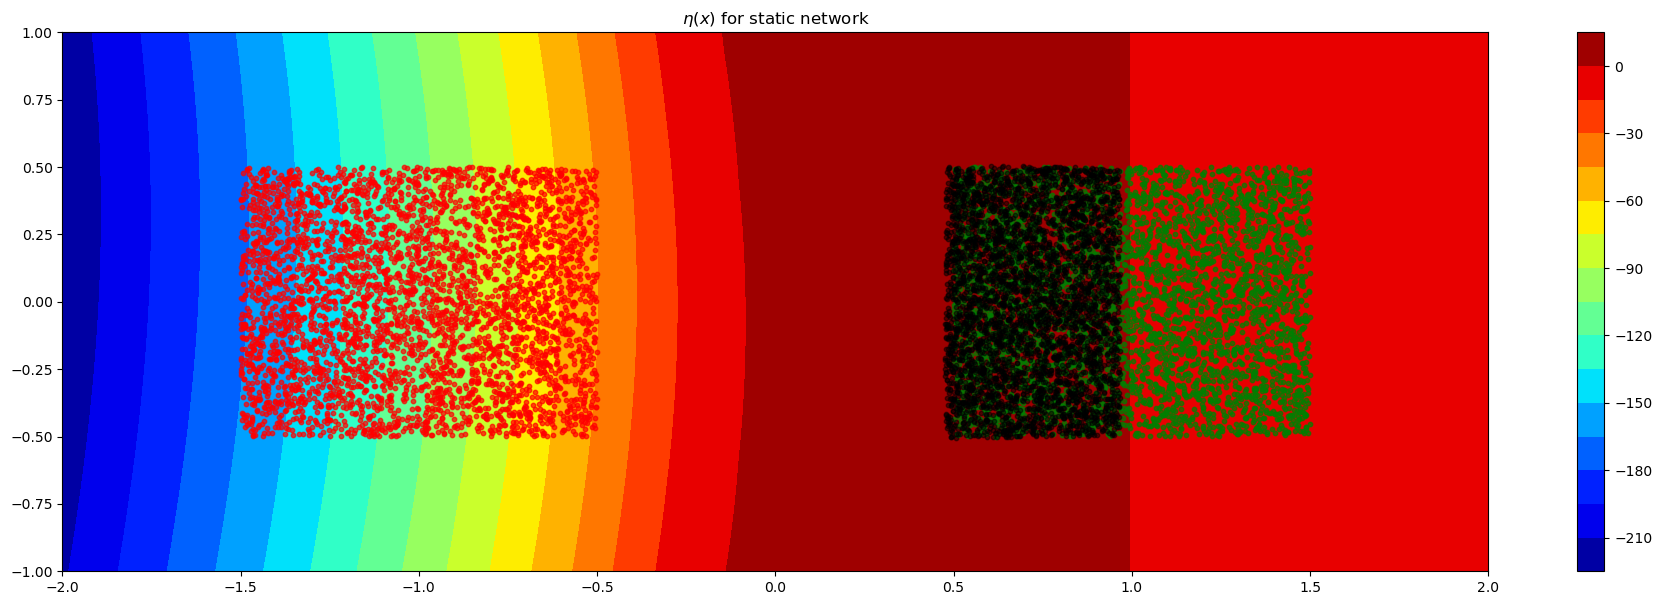

In [17]:
norm = colors.Normalize(vmin=int(round(np.min(outputs),-1)), vmax=int(round(np.max(outputs)))) 
plt.figure(figsize=(23,7))
plt.contourf(xx0, yy0, (outputs), cmap="jet", levels=20)
plt.colorbar()
plt.scatter(DATA_0[:,0], DATA_0[:,1], s = 10, fc="r", alpha=0.7)
plt.scatter(DATA_1[:,0], DATA_1[:,1], s = 10, fc = "g", alpha=0.7)
plt.scatter(x_t1p[:,0], x_t1p[:,1], s = 10, fc="k", alpha=0.5)
plt.title("$\eta(x)$ for static network")

Text(0.5, 1.0, '$\\eta(x)$ for static network')

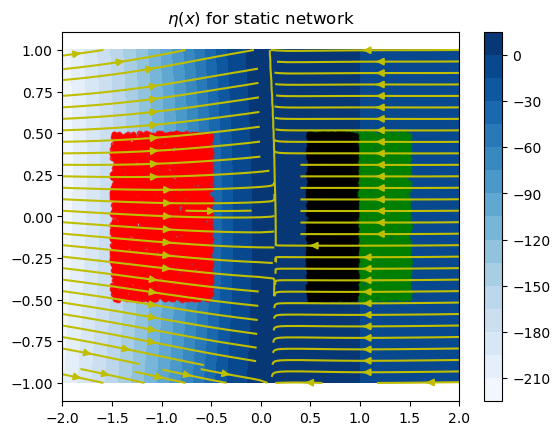

In [18]:
norm = colors.Normalize(vmin=int(round(np.min(outputs),-1)), vmax=int(round(np.max(outputs)))) 

plt.contourf(xx0, yy0, outputs, cmap="Blues", levels=20)
plt.colorbar()
plt.streamplot(np.array(xx0.T), np.array(yy0.T), grad_eta[..., 0].T, grad_eta[..., 1].T, color="y")
plt.scatter(DATA_0[:,0], DATA_0[:,1], s = 10, fc="r", alpha=0.7)
plt.scatter(DATA_1[:,0], DATA_1[:,1], s = 10, fc = "g", alpha=0.7)
plt.scatter(x_t1p[:,0], x_t1p[:,1], s = 10, fc="k", alpha=0.5)

plt.title("$\eta(x)$ for static network")
